In [1]:
#ipcluster start -n 4
# on correct directory

In [2]:
from __future__ import print_function
import os
import pickle
import time

import numpy as np

from IPython.parallel import Client

In [3]:
f = open('max_chro_pos.pickle')
max_chro_pos = pickle.load(f)
f.close()

window_size = 2000000

def get_blocks():
    for chro, max_pos in max_chro_pos.items():
        num_bin = (max_pos + 1) // window_size
        for my_bin in range(num_bin):
            start_pos = my_bin * window_size + 1
            end_pos = start_pos + window_size
            yield chro, start_pos, end_pos

In [4]:
cl = Client()
all_engines = cl[:]
all_engines.execute('import os')
#all_engines.execute('import pickle')
all_engines.execute('import numpy as np')

<AsyncResult: execute>

In [5]:
def compute_MAFs():
    for chrom, start_pos, end_pos in my_blocks:
        os.system('plink --bfile tsi --freq --out tsi-%d-%d --chr %d --from-bp %d --to-bp %d' %
                      (chrom, start_pos, chrom, start_pos, end_pos))
        os.remove('tsi-%d-%d.log' % (chrom, start_pos))

In [6]:
def parse_MAFs(pos):
    chrom, start_pos, end_pos = pos
    mafs = []
    try:
        f = open('tsi-%d-%d.frq' % (chrom, start_pos))
        f.readline()
        for cnt, l in enumerate(f):
            toks = [tok for tok in l.rstrip().split(' ') if tok != '']
            maf = float(toks[-2])
            mafs.append(maf)
        f.close()
    except:
        # might be empty if there are no SNPs
        pass
    return mafs

In [7]:
@all_engines.parallel(block=True)
def compute_means_with_pos(pos):
    block_mafs = parse_MAFs(pos)
    nobs = len(block_mafs)
    if nobs > 0:
        return np.mean(block_mafs), nobs
    else:
        return 0.0, 0

@all_engines.parallel(block=True)
def compute_means_with_mafs(block_mafs):
    nobs = len(block_mafs)
    if nobs > 0:
        return np.mean(block_mafs), nobs
    else:
        return 0.0, 0

In [8]:
all_engines.scatter('my_blocks', list(get_blocks()))
all_engines.apply_sync(compute_MAFs)

[None, None, None, None]

In [9]:
#need compute means with poses!
all_engines.push({'parse_MAFs': parse_MAFs})
%timeit compute_means_with_pos.map(get_blocks())

1 loops, best of 3: 2.34 s per loop


In [10]:
def compute_with_blocks():
    block_mafs = all_engines.map_sync(parse_MAFs, get_blocks())
    block_means = compute_means_with_mafs.map(block_mafs)
    return block_means
    #bring data to the main application
%timeit compute_with_blocks()

1 loops, best of 3: 2.5 s per loop


In [11]:
block_means = compute_means_with_pos.map(get_blocks())
sum_maf = 0.0
cnt_maf = 0
for block_maf, block_cnt in block_means:
    sum_maf += block_maf * block_cnt 
    cnt_maf += block_cnt
print(cnt_maf, sum_maf / cnt_maf)

1222126 0.23159641651


In [12]:
#blocks are already scattered
async = all_engines.apply_async(compute_MAFs)
import time
#print(async.metadata)
while not async.ready():
    print(len(async), async.progress)
    time.sleep(5)
print('Done')

4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
4 0
Done


## Load balancer

In [13]:
load_balancer = cl.load_balanced_view()

In [14]:
async = load_balancer.map(parse_MAFs,
                          [pos for pos in get_blocks() if pos[0] == 1],
                          block=False, chunksize=3, ordered=True)
while not async.ready():
    print(len(async), async.progress)
    time.sleep(1)
print('Done')

41 0
Done


In [15]:
result = async.get()

/home/tra/anaconda3/envs/bio2/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/tra/anaconda3/envs/bio2/lib/python2.7/site-packages/numpy/core/_methods.py:71: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


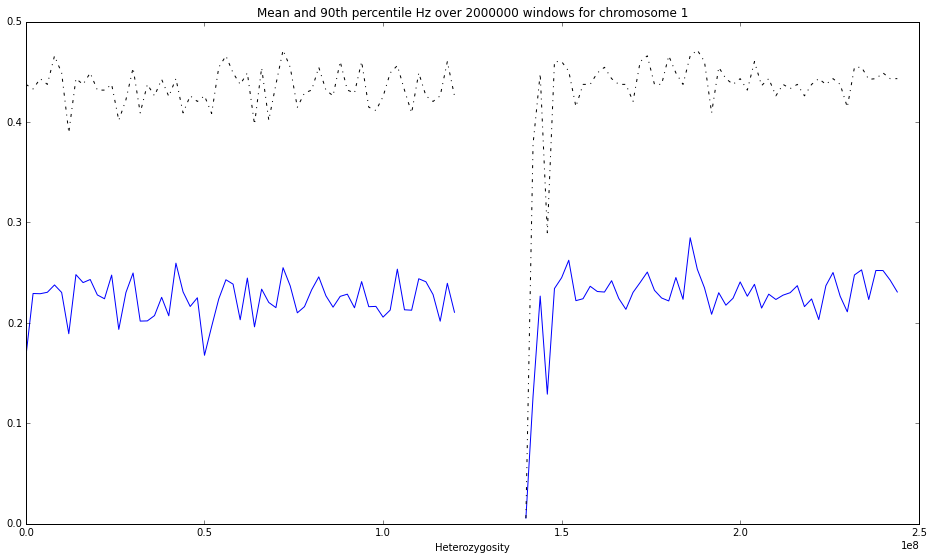

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
xs = [x * window_size for x in range(len(result))]
ax.plot(xs, [np.mean(vals) for vals in result])
ax.plot(xs, [(lambda x : np.percentile(x, 90) if len(x) > 0 else None)(vals) for vals in result], 'k-.')
ax.set_xlabel('Chromosome position')
ax.set_xlabel('Heterozygosity')
ax.set_title('Mean and 90th percentile Hz over %d windows for chromosome 1' % window_size)